# Map matching with Meili from Valhalla
This notebook is to illustarte the map matching with the help of Valhalla which is a opensource routing engine. Here the objective is to fetch the data from its REST API in python and display it in figure. A full documentation can be found [here](https://ikespand.github.io/posts/meili/).

In [1]:
import os
import pandas as pd
import requests
import json
from rasta.gpx import GpxParser
import polyline
import matplotlib.pyplot as plt
from rasta.rasta_kepler import RastaKepler # Optional

In [2]:
def __process_gpx_file(file_name):
    """A wrapper function to read a GPX file and provide a df according to meili.
    """
    gpx_instance = GpxParser(file_name, calculate_distance=True)
    # Extract our data in a dataframe
    df = gpx_instance.data
    df= df.drop(["altitude","time", "distance"], axis=1)
    df['time'] = df.index 
    df = df.rename(columns={"longitude": "lon", "latitude": "lat"})
    return df #, html_path, vis

def create_meli_req(df_trip):
    """Returns the body for meili for its request.
    """
    # Providing needed data for the body of Meili's request
    meili_coordinates = df_trip.to_json(orient='records')
    meili_head = '{"shape":'
    meili_tail = ""","search_radius": 150, "shape_match":"map_snap", "costing":"auto", "format":"osrm"}"""
    meili_request_body = meili_head + meili_coordinates + meili_tail
    return meili_request_body

In [3]:
# Get the gpx trajectory (can be recorded from your phone)
df_trip = __process_gpx_file(r"./07-Dec-2020-1800.gpx")
df_trip.head(5)

,lon,lat,speed,time
0,9.058879,48.658368,0.000000,0
1,9.058892,48.658348,9.047768,1
2,9.058891,48.658307,16.036161,2
3,9.058877,48.658249,23.683554,3
4,9.058870,48.658180,27.878781,4


There are 2 routes for map matching. Endpoint `/route` and `/trace_attributes` differs in a way what they return. Here, using the 2nd one because it will give us the attributes of road e.g. speed limits, road tags etc. More information can be found [here](https://valhalla.readthedocs.io/en/latest/api/map-matching/api-reference/).

In [4]:
# Providing headers to the request
meili_request_body = create_meli_req(df_trip)
headers = {'Content-type': 'application/json'}
trace_url = "http://localhost:8002/trace_attributes"

In [5]:
# Sending a request yo meili and transform data
r = requests.post(trace_url, data=str(meili_request_body), headers=headers)
response_text = r.json()
# Following are the keys in the response
print(response_text.keys())

dict_keys(['matched_points', 'edges', 'admins', 'raw_score', 'shape', 'confidence_score', 'osm_changeset', 'alternate_paths'])


In [6]:
# For now, just extract the matched points
matched_df = pd.DataFrame()
matched_df["lat"] = [i[0] for i in polyline.decode(response_text['shape'], 6)]
matched_df["lon"] = [i[1] for i in polyline.decode(response_text['shape'], 6)]
matched_df.head()

,lat,lon
0,48.658364,9.058932
1,48.658320,9.058923
2,48.658147,9.058887
3,48.658059,9.058868
4,48.658017,9.058859


Visualize with matplotlib with a simple scatter plot

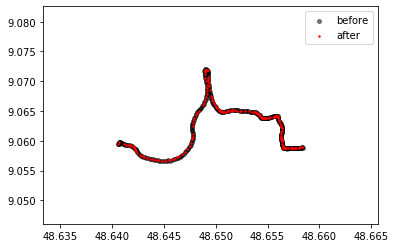

In [12]:
plt.scatter(df_trip["lat"], df_trip["lon"], s=15, c='k', label='before', alpha=0.5)
plt.scatter(matched_df["lat"], matched_df["lon"], s=2, c='r', label='after')
plt.legend()

Let's visualize directly on the map. For the same, you should have a [MAPBOX](https://account.mapbox.com/access-tokens/) API key. My API key is in bashrc file, therefore, I am importing it from environment. You can also paste it here in string form.

In [8]:
MAPBOX_API_KEY = os.environ['MAPBOX_API_KEY'] 
visualizer = RastaKepler(api_key=MAPBOX_API_KEY,
                         style="Dark")
visualizer.add_data(data=df_trip, names="Before")
visualizer.add_data(data=matched_df, names="After")

C:\Users\sandeep.pandey\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\rasta\keplergl_config.json
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [9]:
visualizer.map.height = 800
visualizer.map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [], 'interactionConfig': {'…

In case, if we want to see the attributes of matched edges, then we can look into `edges` as following:

In [10]:
response_text["edges"]

[{'end_node': {'transition_time': 0.019,
   'type': 'street_intersection',
   'admin_index': 0,
   'elapsed_time': 1.751,
   'intersecting_edges': [{'road_class': 'service_other',
     'use': 'driveway',
     'begin_heading': 96,
     'to_edge_name_consistency': False,
     'from_edge_name_consistency': False,
     'driveability': 'both',
     'cyclability': 'both',
     'walkability': 'both'}]},
  'names': ['Böblinger Straße', 'L 1185'],
  'speed': 50,
  'road_class': 'secondary',
  'begin_heading': 188,
  'begin_shape_index': 0,
  'traversability': 'both',
  'use': 'road',
  'drive_on_right': False,
  'speed_limit': 50,
  'max_upward_grade': 32768,
  'travel_mode': 'drive',
  'density': 4,
  'end_shape_index': 2,
  'bicycle_network': 0,
  'max_downward_grade': 32768,
  'end_heading': 188,
  'mean_elevation': 32768,
  'length': 0.024,
  'lane_count': 1,
  'weighted_grade': 0.0,
  'way_id': 194855296,
  'id': 4972364568169,
  'surface': 'paved_smooth',
  'vehicle_type': 'car'},
 {'end_